# NEMA Photoelectric

- Photoelectric interaction in PETALO

In [1]:
import Pkg

In [2]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase", "PhysicalConstants"]);

In [3]:
Pkg.add.(["Test"]);

In [4]:
Pkg.add.(["VegaLite","VegaDatasets"]);

In [5]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [861]:
Pkg.add("Distributions") 

In [862]:
using Distributions

In [6]:
using LsqFit
using GLM

In [7]:
using HTTP
using Plots
using VegaLite
using VegaDatasets
using DataFrames
using HDF5
using DrWatson
using Test
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [8]:
using Glob
using CSV

In [9]:
using Statistics
using StatsBase
using Printf

In [10]:
using Logging

In [11]:
@quickactivate "JPetalo"

In [12]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [13]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [14]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [1225]:
include(srcdir("jpetalo.jl"))

Main.JPetalo

In [16]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, ps, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J,
	mW, μW, W,
    A, N, mol, mmol, V, L, mL, μL, M

In [17]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

In [1543]:
include(srcdir("jpetalo.jl"))

Main.JPetalo

In [1542]:
loglevel("Info")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(42) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

In [1371]:
function xfitg(data)
    ft =  fit(Normal,data)
    return gausg(ft.μ,ft.σ, length(data))
end

xfitg (generic function with 1 method)

In [1307]:
function gausg(μ, σ, C)
    function gausx(x)
        return C * pdf(Normal(μ, σ,), x)
    end
    return gausx
end

gausg (generic function with 1 method)

In [1403]:
function gausg2(μ1, σ1, C1, μ2, σ2, C2)
    function gausx(x)
        return C1 * pdf(Normal(μ1, σ1,), x) + C2 * pdf(Normal(μ2, σ2,), x)
    end
    return gausx
end

gausg2 (generic function with 1 method)

In [1308]:
@. gauss1(x, p) = p[1]* pdf(Normal(p[2], p[3]), x)

gauss1 (generic function with 1 method)

In [1411]:
function gauss2fm(mu)
    function gauss2(x,p)
        return @. p[1]* pdf(Normal(mu, p[2]), x) + p[3]* pdf(Normal(mu, p[4]), x)
    end
    return gauss2
end

gauss2fm (generic function with 1 method)

In [1470]:
function gauss1fm(mu)
    function gauss1(x,p)
        return @. p[1]* pdf(Normal(mu, p[2]), x)
    end
    return gauss1
end

gauss1fm (generic function with 1 method)

In [1460]:
function gfit_gauss(y, xmin, xmax, bins=25, ff=gauss1)

    # fit the unbinned distribution
    x  =  JPetalo.in_range(y, xmin, xmax)
    ft =  fit(Normal,x)
    @debug "initial mean and std" ft.μ ft.σ

    # bin distribution
    h = JPetalo.hist1d(x, bins, xmin, xmax)
    c = centers(h)
    w = h.weights
    @debug "histo w and c"  w c

    # fit parameters lb, ub, po are lower, upper bounds and pars
    lb = [sum(w)/1000.0, ft.μ - 5*ft.σ, ft.σ/10.0]
    ub = [sum(w)*1000.0, ft.μ + 5*ft.σ, 10*ft.σ]
    p0_bounds = [sum(w)/10.0, ft.μ, ft.σ]
    fq = curve_fit(ff, c, w, p0_bounds, lower=lb, upper=ub)
    cfq = coef(fq)
    @debug "coef(fq)" cfq
    CC, mu, sigma  = coef(fq)
    
    @debug "coef(fq)" CC mu sigma
    gx = gausg(mu, sigma, CC)

    return (mu = mu, sigma = sigma, C = CC, 
            h = h, xg = c, yg = gx.(c), gx = gx)
end

gfit_gauss (generic function with 3 methods)

In [1467]:
mean_and_std([1,2,3])

(2.0, 1.0)

In [1472]:
function gfit_xgauss(y, xmin, xmax, bins=25, fm=0.0)

    # fit the unbinned distribution
    x  =  JPetalo.in_range(y, xmin, xmax)
    mu, sigma =  mean_and_std(x)
    @debug "initial std" sigma

    # bin distribution
    h = JPetalo.hist1d(x, bins, xmin, xmax)
    c = centers(h)
    w = h.weights
    @debug "histo w and c"  w c

    # fit parameters lb, ub, po are lower, upper bounds and pars
    lb = [sum(w)/1000.0,  sigma/10.0]
    ub = [sum(w)*1000.0, 10*sigma]
    p0_bounds = [sum(w)/10.0, sigma]
    
    ff = gauss1fm(fm)
    fq = curve_fit(ff, c, w, p0_bounds, lower=lb, upper=ub)
    cfq = coef(fq)
    @debug "coef(fq)" cfq
    CC, sigma  = coef(fq)
    
    @debug "coef(fq)" CC  sigma
    gx = gausg(fm, sigma, CC)

    return (mu = fm, sigma = sigma, C = CC, 
            h = h, xg = c, yg = gx.(c), gx = gx)
end

gfit_xgauss (generic function with 5 methods)

In [1531]:
function gfit_gauss2_cmean(y, xmin, xmax, bins, sigmas, cs, cmean=0.0)

    
    x =  JPetalo.in_range(y, xmin, xmax)
    h = JPetalo.hist1d(x, bins, xmin, xmax)
    c = centers(h)
    w = h.weights
    @debug "histo centers and weights in full region"  w c

    g2 = gauss2fm(cmean)
    # fit parameters lb, ub, po are lower, upper bounds and pars
    
    lb = [cs[1]/10.0, sigmas[1]/2.0, cs[2]/10.0, sigmas[2]/2.0]
    ub = [cs[1]*10.0, sigmas[1]*2.0, cs[2]*10.0, sigmas[2]*2.0]
    p0_bounds = [cs[1], sigmas[1], cs[2], sigmas[2]]
    
    @debug "pars" p0 lb ub
    # fit double gaussian
    fq = curve_fit(g2, c, w, p0_bounds, lower=lb, upper=ub)
    C1, sigma1, C2,  sigma2   = coef(fq)
    @debug "C1 sigma1 C2 sigma2" C1 sigma1 C2  sigma2

    #
    gx = gausg2(cmean, sigma1, C1, cmean, sigma2, C2)
    gx1 = gausg(cmean, sigma1, C1)
    gx2 = gausg(cmean, sigma2, C2)
    return (sigma1 = sigma1, sigma2 = sigma2, C1 = C1, C2=C2,
            h = h, xg = c, yg = gx.(c), gx = gx, gx1=gx1, gx2=gx2)
    end


gfit_gauss2_cmean (generic function with 4 methods)

### generate random data for 1 g

In [1311]:
dx = Normal(100.0, 5.0)

Normal{Float64}(μ=100.0, σ=5.0)

In [1365]:
 data = rand(dx, 50000);

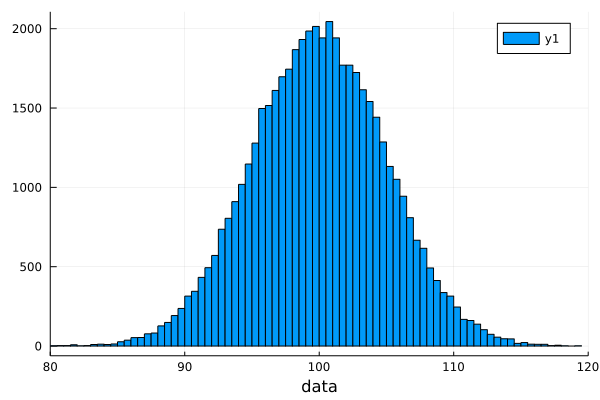

In [1366]:
xi = 80.
xs = 120.
h = JPetalo.hist1d(data, 100, xi, xs)
p = plot(h, xlim=(xi, xs), xlabel="data")

### Fits 

In [1367]:
fit(Normal,data)

Normal{Float64}(μ=100.00174470957165, σ=4.992626716268252)

In [1368]:
JPetalo.mean_std(data, xi, xs)

(100.00050464179417, 4.988725258655289)

In [1381]:
sum(data) / 100

50000.87235478587

In [1400]:
gf = gfit_gauss(data, xi, xs, 200);

In [1401]:
gf.C

10012.629414685938

In [1374]:
xf = xfitg(data)

(::var"#gausx#354"{Float64, Float64, Int64}) (generic function with 1 method)

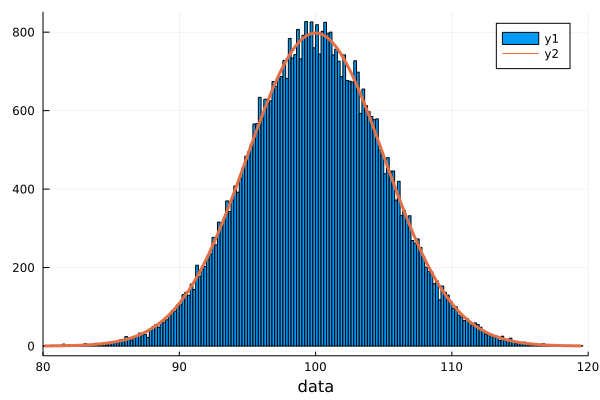

In [1402]:
h = JPetalo.hist1d(data, 200, xi, xs)
p = plot(h, xlim=(xi, xs), xlabel="data")
p = plot!(p, gf.xg, gf.yg, lw=3)

### Generate random data for two gaussian common mean at zero

In [1490]:
d1 = Normal(0.0, 5.0)
d2 = Normal(0.0, 25.0)
dat1 = rand(d1, 50000)
data = copy(dat1)
dat2 = rand(d2, 50000)
append!(data,dat2)
xi = -75.
xs = 75.


75.0

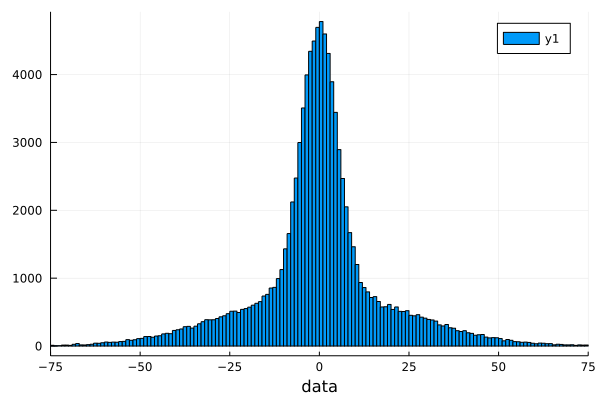

In [1491]:
h = JPetalo.hist1d(data, 200, xi, xs)
p = plot(h, xlim=(xi, xs), xlabel="data")

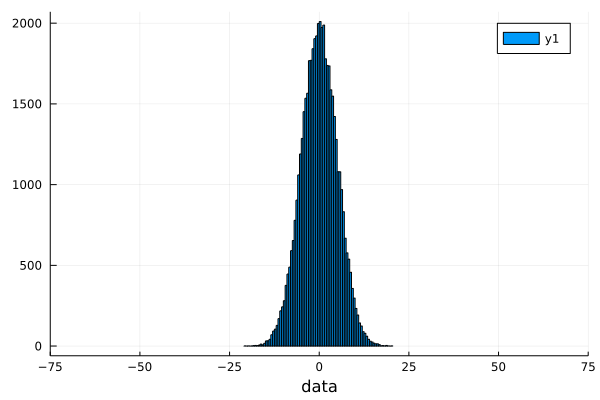

In [1481]:
h = JPetalo.hist1d(dat1, 100, xi, xs)
p = plot(h, xlim=(xi, xs), xlabel="data")

In [1475]:
gf = gfit_xgauss(dat2, -75.,-25.,50);

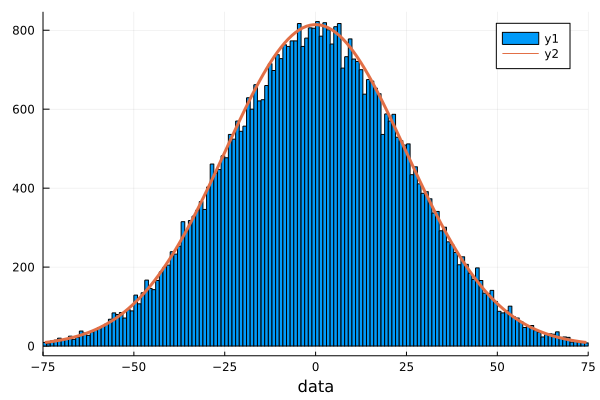

In [1476]:
h = JPetalo.hist1d(dat2, 150, -75.0, 75.0)
cc = JPetalo.centers(h)
p = plot(h, xlim=(xi, xs), xlabel="data")
p = plot!(p, cc, gf.gx.(cc), lw=3)

In [1479]:
gf.sigma

24.842795679448493

In [1486]:
gf = gfit_xgauss(dat1, -15.,15.,60);

┌ Debug: initial std
│   sigma = 4.9412701958976015
└ @ Main In[1472]:6
┌ Debug: histo w and c
│   w = [32, 33, 42, 70, 93, 105, 128, 170, 218, 243, 281, 376, 446, 489, 591, 654, 779, 904, 1060, 1190, 1286, 1452, 1535, 1566, 1768, 1770, 1842, 1904, 1921, 1998, 2010, 1973, 1988, 1779, 1738, 1735, 1587, 1548, 1422, 1280, 1080, 1079, 969, 832, 668, 577, 538, 457, 357, 297, 233, 192, 143, 124, 89, 79, 61, 42, 30, 25]
│   c = [-14.75, -14.25, -13.75, -13.25, -12.75, -12.25, -11.75, -11.25, -10.75, -10.25, -9.75, -9.25, -8.75, -8.25, -7.75, -7.25, -6.75, -6.25, -5.75, -5.25, -4.75, -4.25, -3.75, -3.25, -2.75, -2.25, -1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75, 6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75]
└ @ Main In[1472]:12
┌ Debug: coef(fq)
│   cfq = [25038.411703514375, 5.0304302543180635]
└ @ Main In[1472]:22
┌ Debug: coef(fq)
│   CC = 25038.411703514375
│   sig

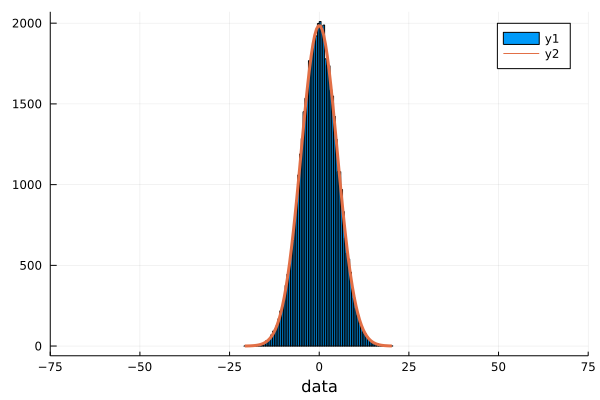

In [1487]:
h = JPetalo.hist1d(dat1, 150, -75.0, 75.0)
cc = JPetalo.centers(h)
p = plot(h, xlim=(xi, xs), xlabel="data")
p = plot!(p, cc, gf.gx.(cc), lw=3)

In [1524]:
gf1 = gfit_xgauss(data, -75.,-25.,50);
@info gf1

┌ Info: (mu = 0.0, sigma = 25.186277171512927, C = 49908.755195532394, h = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}}
│ edges:
│   -75.0:1.0:-25.0
│ weights: [11, 6, 6, 14, 14, 10, 26, 37, 17, 16, 21, 27, 43, 41, 49, 59, 54, 58, 56, 66, 69, 95, 85, 93, 109, 113, 140, 141, 130, 148, 152, 179, 188, 182, 230, 240, 252, 285, 290, 265, 293, 328, 359, 388, 386, 387, 406, 431, 446, 477]
│ closed: left
│ isdensity: false, xg = [-74.5, -73.5, -72.5, -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5, -26.5, -25.5], yg = [9.953758984846294, 11.185355476924954, 12.549540663479663, 14.057925543709612, 15.722804587678509, 17.557155843574296, 19.574635362779453, 21.7895653260

In [1525]:
gf2 = gfit_xgauss(data, -5.,5.,60);
@info gf1

┌ Info: (mu = 0.0, sigma = 25.186277171512927, C = 49908.755195532394, h = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}}
│ edges:
│   -75.0:1.0:-25.0
│ weights: [11, 6, 6, 14, 14, 10, 26, 37, 17, 16, 21, 27, 43, 41, 49, 59, 54, 58, 56, 66, 69, 95, 85, 93, 109, 113, 140, 141, 130, 148, 152, 179, 188, 182, 230, 240, 252, 285, 290, 265, 293, 328, 359, 388, 386, 387, 406, 431, 446, 477]
│ closed: left
│ isdensity: false, xg = [-74.5, -73.5, -72.5, -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5, -26.5, -25.5], yg = [9.953758984846294, 11.185355476924954, 12.549540663479663, 14.057925543709612, 15.722804587678509, 17.557155843574296, 19.574635362779453, 21.7895653260

In [1532]:
gf = gfit_gauss2_cmean(data, xi, xs, 100, [gf1.sigma, gf2.sigma], [gf1.C, gf2.C])

(sigma1 = 25.22475287180564, sigma2 = 5.070134952912933, C1 = 99489.0895689579, C2 = 100621.34306829379, h = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}}
edges:
  -76.0:2.0:76.0
weights: [11, 12, 28, 36, 54, 37, 70, 90, 113, 114  …  113, 95, 78, 77, 54, 51, 34, 29, 31, 15]
closed: left
isdensity: false, xg = [-75.0, -73.0, -71.0, -69.0, -67.0, -65.0, -63.0, -61.0, -59.0, -57.0  …  57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0], yg = [18.93234490815224, 23.890260065125624, 29.9576106572794, 37.33045575304486, 46.22631103609124, 56.8833293308937, 69.55856320500408, 84.52516421141775, 102.06839103870439, 122.48032767600998  …  122.48032767600998, 102.06839103870439, 84.52516421141775, 69.55856320500408, 56.8833293308937, 46.22631103609124, 37.33045575304486, 29.9576106572794, 23.890260065125624, 18.93234490815224], gx = var"#gausx#356"{Float64, Float64, Float64, Float64, Float64, Float64}(0.0, 25.22475287180564,

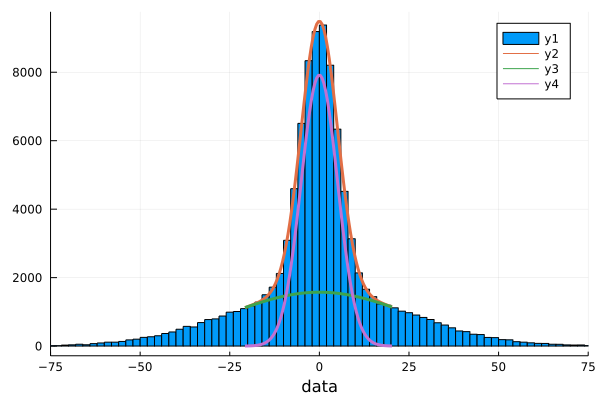

In [1533]:
#h = JPetalo.hist1d(data, 150, xi, xs)
p = plot(gf.h, xlim=(xi, xs), xlabel="data")
p = plot!(p, cc, gf.gx.(cc), lw=3)
p = plot!(p, cc, gf.gx1.(cc), lw=3)
p = plot!(p, cc, gf.gx2.(cc), lw=3)

In [1539]:
function fit_2gauss_cmean(data, gp, g1p, g2p, cm)
    gf1 = gfit_xgauss(data, g1p.xmin,g1p.xmax,g1p.nbin, cm)
    @debug gf1
    gf2 = gfit_xgauss(data, g2p.xmin,g2p.xmax,g2p.nbin, cm)
    @debug gf2
    gf = gfit_gauss2_cmean(data, gp.xmin,gp.xmax,gp.nbin, [gf1.sigma, gf2.sigma], [gf1.C, gf2.C])
    @debug gf
    return gf
end

fit_2gauss_cmean (generic function with 1 method)

In [1540]:
g1p = (xmin= -75.0, xmax= -25.0, nbin=50)
g2p = (xmin= -15.0, xmax=  15.0, nbin=50)
gp  = (xmin= -75.0, xmax=  75.0, nbin=100)
fg = fit_2gauss_cmean(data, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 25.224752862246962
│   fg.sigma2 = 5.07013495213945
└ @ Main In[1540]:5


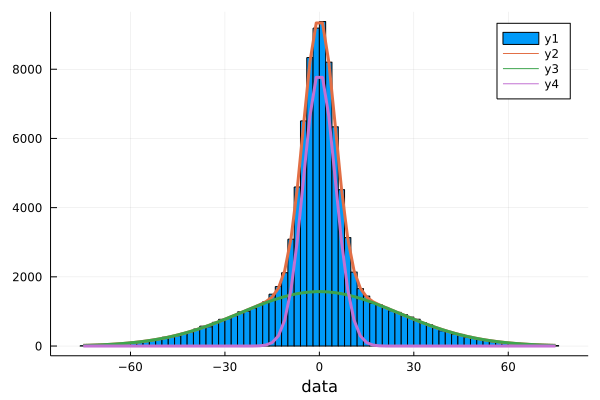

In [1541]:
p = plot(fg.h, xlabel="data")
p = plot!(p,fg.xg, fg.yg, lw=3)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=3)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=3)

In [1545]:
fg = JPetalo.fit_2gauss_cmean(data, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 25.224752862246962
│   fg.sigma2 = 5.07013495213945
└ @ Main In[1545]:2
